In [ ]:
#COST  ticker  Costco

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

from yahoo_fin.stock_info import get_data

In [ ]:
#interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

In [27]:
api_df= get_data("cost", start_date="12/04/2010", end_date="07/04/2022", index_as_date = False, interval="1d")
api_df

,date,open,high,low,close,adjclose,volume,ticker
0,2010-12-06,68.330002,69.410004,68.330002,69.190002,51.941883,3366000,COST
1,2010-12-07,69.699997,70.059998,69.120003,69.639999,52.279705,5115400,COST
2,2010-12-08,69.379997,69.709999,68.529999,69.250000,51.986916,3691400,COST
3,2010-12-09,69.699997,71.129997,69.279999,71.019997,53.315689,6777000,COST
4,2010-12-10,70.750000,71.279999,70.620003,71.250000,53.488342,3555900,COST
...,...,...,...,...,...,...,...,...
2908,2022-06-27,485.809998,487.239990,477.350006,481.750000,480.919891,2034700,COST
2909,2022-06-28,483.500000,487.239990,467.890015,468.609985,467.802521,1754600,COST
2910,2022-06-29,470.950012,472.970001,466.420013,469.839996,469.030396,1275600,COST
2911,2022-06-30,468.299988,482.089996,464.720001,479.279999,478.454132,3852400,COST


In [28]:
#print the summary 
print(api_df.describe())

              open         high          low        close     adjclose  \
count  2913.000000  2913.000000  2913.000000  2913.000000  2913.000000   
mean    203.651806   205.379911   201.949835   203.752877   188.721383   
std     122.687837   124.091356   121.321125   122.772123   127.996799   
min      68.330002    69.410004    68.330002    69.190002    51.941883   
25%     114.570000   115.190002   113.919998   114.620003    95.486511   
50%     157.300003   158.380005   156.199997   157.130005   141.105591   
75%     279.829987   280.989990   276.869995   279.850006   265.959595   
max     607.280029   612.270020   597.729980   608.049988   606.016296   

             volume  
count  2.913000e+03  
mean   2.363662e+06  
std    1.281709e+06  
min    4.910000e+05  
25%    1.621500e+06  
50%    2.070000e+06  
75%    2.683000e+06  
max    2.423300e+07  


In [29]:
#prep the data 
api_df.set_index(pd.DatetimeIndex(api_df['date']), inplace=True)

In [30]:
#Keep the close for 2014-19
api_df = api_df[['close']]
api_df

,close
date,
2010-12-06,69.190002
2010-12-07,69.639999
2010-12-08,69.250000
2010-12-09,71.019997
2010-12-10,71.250000
...,...
2022-06-27,481.750000
2022-06-28,468.609985
2022-06-29,469.839996


In [31]:
print (api_df.index.max())

2022-07-01 00:00:00


In [32]:
data = api_df.filter(['close'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len =math.ceil(len(dataset) *.7)
train_data =scaled_data[0:training_data_len , : ]


X_train_data = []
y_train_data = []

for i in range(1500,len(train_data)):
    X_train_data=list(X_train_data)
    y_train_data=list(y_train_data)
    X_train_data.append(train_data[i-1500:i,0])
    y_train_data.append(train_data[i,0])
    
    X_train_data1, y_train_data1 = np.array(X_train_data), np.array(y_train_data)
    
    X_train_data2 = np.reshape(X_train_data1,(X_train_data1.shape[0],X_train_data1.shape[1],1))

   
    
#1500 = number of days you can change it accordingly. 

# There will be a total of 60 values, 1st column will contain an index of 0-59
# The second will have an index of 1-60 ++_
# the y_train has the 60 st value on c1 and c2 will have 61++

In [33]:
#Build the LSTM MODEL 

model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_data2.shape[1],1)))

model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))

model.add(Dense(units=1))

In [34]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_data2, y_train_data1, batch_size=1, epochs=1)

540/540 [==============================] - 317s 580ms/step - loss: 6.1339e-04


In [35]:
test_data = scaled_data[training_data_len -1500: , : ]

X_test = []

y_test = dataset[training_data_len : , : ]

for i in range(1500,len(test_data)):
    
    X_test.append(test_data[i-1500:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)

28/28 [==============================] - 10s 330ms/step


In [36]:
# Error calculation where RMSE = root mean squared error 

rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

In [37]:
print(rmse)

34.91643194350444


C:\Users\rctay\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


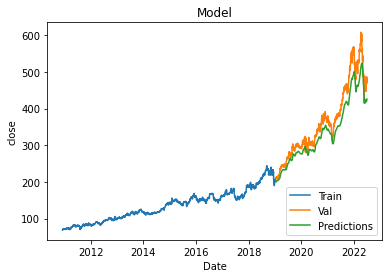

In [38]:
#Predict and visualize 

train = api_df[:training_data_len]

valid = api_df[training_data_len:]

valid['Predictions'] = predictions

plt.title('Model')

plt.xlabel('Date')

plt.ylabel('close')

plt.plot(train['close'])

plt.plot(valid[['close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

<AxesSubplot:xlabel='date'>

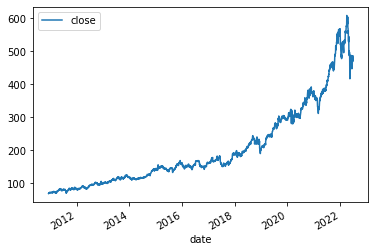

In [39]:
api_df.plot()